In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

# Upload the (cleaned) data

In [2]:
data = pd.read_csv('../data/processed/DecisionTreeData2010.csv', index_col=0)
data.sort_index(inplace=True)
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,Cost,PREDDEG_N,Governance,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,Complete,RetentionFT,RetentionPT
0,00100200,alabama a & m university,Normal,1,3,4,1,5.0,0.5129,4930.0,...,13762.0,Bachelor,Public,xl,high,high,high,0.3306,0.7457,0.5000
1,00105200,university of alabama at birmingham,Birmingham,1,3,4,1,5.0,0.8243,10661.0,...,18003.0,Bachelor,Public,xl,high,highest,highest,0.4108,0.7997,0.7000
2,02503400,amridge university,Montgomery,1,3,4,2,5.0,0.7143,370.0,...,20700.0,Bachelor,Private nonprofit,medium,highest,med,low,0.2308,0.8000,NaN
3,00105500,university of alabama at huntsville,Huntsville,1,3,4,1,5.0,0.6614,5828.0,...,17064.0,Bachelor,Public,xl,high,high,highest,0.4364,0.7545,0.5385
4,00100500,alabama state university,Montgomery,1,3,4,1,5.0,0.4372,4882.0,...,14390.0,Bachelor,Public,xl,high,high,high,0.2399,0.6352,0.4167


## Separate the school identity information
This can be merged with the results later, to link model predictions with school names.

In [3]:
identity = data[['OPEID','INSTNM', 'CITY', 'Governance', 'PREDDEG_N']]
identity.shape

(30682, 5)

## Separate the closed schools from the database
Explore the counts and distrubtion of the closed schools, and resample to balance the database.

In [4]:
closed = data.loc[data.CURROPER == False]
closed.shape

(2759, 33)

In [5]:
closed.PREDDEG_N.value_counts()

Certificate       1841
Associates         325
Not classified     253
Bachelor           241
Graduate            99
Name: PREDDEG_N, dtype: int64

In [6]:
closed_degree = closed.pivot_table(index='PREDDEG_N', columns=['CONTROL'], aggfunc='size')
print(closed_degree)

CONTROL           1    2     3
PREDDEG_N                     
Associates       42   26   257
Bachelor         13   94   134
Certificate     117  147  1577
Graduate          1   40    58
Not classified   27   35   191


In [7]:
# Resample the minority class
from sklearn.utils import resample
closed_upsample = resample(closed, replace=True, n_samples=closed.shape[0]*2, random_state=123)

## Separate the currently operating school and filter by year

In [8]:
open_df = data.loc[data.CURROPER==True]
open_df.shape

(27923, 33)

In [9]:
current = open_df.loc[data.Year > 2012]
current.shape

(7440, 33)

In [10]:
current.PREDDEG_N.value_counts()

Certificate       3093
Bachelor          2100
Associates        1488
Not classified     473
Graduate           286
Name: PREDDEG_N, dtype: int64

In [11]:
current_degree = current.pivot_table(index='PREDDEG_N', columns=['CONTROL'], aggfunc='size')
print(current_degree)

CONTROL           1     2     3
PREDDEG_N                      
Associates      780   163   545
Bachelor        588  1241   271
Certificate     594   199  2300
Graduate         15   236    35
Not classified   75    89   309


## Merge the filtered open schools with the upsampled closed schools

In [12]:
data = pd.concat([current, closed_upsample], axis = 0)
data.shape

(12958, 33)

In [13]:
data.CURROPER.value_counts()

True     7440
False    5518
Name: CURROPER, dtype: int64

In [14]:
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,Cost,PREDDEG_N,Governance,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,Complete,RetentionFT,RetentionPT
22882,00100200,alabama a & m university,Normal,1,3,4,1,5.0,0.8989,4051.0,...,18888.0,Bachelor,Public,xl,high,high,high,0.2914,0.6314,0.5000
22883,00105200,university of alabama at birmingham,Birmingham,1,3,4,1,5.0,0.8673,11200.0,...,19990.0,Bachelor,Public,xl,high,highest,highest,0.5377,0.8016,0.5000
22884,02503400,amridge university,Montgomery,1,3,4,2,5.0,NaN,322.0,...,12300.0,Bachelor,Private nonprofit,medium,highest,med,low,0.6667,0.3750,0.3333
22885,Other,university of alabama in huntsville,Huntsville,1,3,4,1,5.0,0.8062,5525.0,...,20306.0,Bachelor,Public,xl,high,high,highest,0.4835,0.8098,0.4444
22886,00100500,alabama state university,Montgomery,1,3,4,1,5.0,0.5125,5354.0,...,17400.0,Bachelor,Public,xl,high,high,high,0.2517,0.6219,0.3023


## Basic EDA with the resampled and filtered data

In [15]:
data['PREDDEG_N'].value_counts()

Certificate       6762
Bachelor          2594
Associates        2126
Not classified     979
Graduate           497
Name: PREDDEG_N, dtype: int64

In [16]:
print(data.Governance.value_counts())

Private for-profit    7844
Private nonprofit     2646
Public                2468
Name: Governance, dtype: int64


In [17]:
control_degree = data.pivot_table(index='PREDDEG_N', columns=['CONTROL','CURROPER'], aggfunc='size')
print(control_degree)

CONTROL            1           2           3      
CURROPER       False True  False True  False True 
PREDDEG_N                                         
Associates        88   780    60   163   490   545
Bachelor          21   588   179  1241   294   271
Certificate      247   594   313   199  3109  2300
Graduate           5    15    95   236   111    35
Not classified    55    75    71    89   380   309


## Drop columns not needed for analysis

In [18]:
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins','Governance',\
           'TuitionBins','ExpenditureBins','FacultyBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year', 'PREDDEG_N']
df = data.drop(to_drop, axis=1)
df.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT
22882,1,3,1,4051.0,True,9063.0,7459.0,0.8856,0.1049,0.256983,0.228252,0.150838,19500.0,18888.0,0.2914,0.6314
22883,1,3,1,11200.0,True,9033.0,17208.0,0.9106,0.2422,0.445502,0.184674,0.113279,16250.0,19990.0,0.5377,0.8016
22884,1,3,2,322.0,True,12057.0,5123.0,0.6721,0.8540,0.288591,0.382550,0.037529,10500.0,12300.0,0.6667,0.3750
22885,1,3,1,5525.0,True,8322.0,9352.0,0.6555,0.2640,0.377617,0.149758,0.116747,16500.0,20306.0,0.4835,0.8098
22886,1,3,1,5354.0,True,7813.0,7393.0,0.6641,0.1270,0.183563,0.256749,0.109778,15854.5,17400.0,0.2517,0.6219


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12958 entries, 22882 to 6665
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          12958 non-null  int64  
 1   PREDDEG            12958 non-null  int64  
 2   CONTROL            12958 non-null  int64  
 3   UGDS               12958 non-null  float64
 4   CURROPER           12958 non-null  bool   
 5   TUITFTE            12958 non-null  float64
 6   INEXPFTE           12958 non-null  float64
 7   PFTFAC             12958 non-null  float64
 8   UG25abv            12958 non-null  float64
 9   COMP_ORIG_YR4_RT   12958 non-null  float64
 10  WDRAW_ORIG_YR4_RT  12958 non-null  float64
 11  ENRL_ORIG_YR4_RT   12958 non-null  float64
 12  DEBT_MDN           12958 non-null  float64
 13  Cost               12958 non-null  float64
 14  Complete           12958 non-null  float64
 15  RetentionFT        12958 non-null  float64
dtypes: bool(1), float64

In [20]:
df.isnull().sum()

NUMBRANCH            0
PREDDEG              0
CONTROL              0
UGDS                 0
CURROPER             0
TUITFTE              0
INEXPFTE             0
PFTFAC               0
UG25abv              0
COMP_ORIG_YR4_RT     0
WDRAW_ORIG_YR4_RT    0
ENRL_ORIG_YR4_RT     0
DEBT_MDN             0
Cost                 0
Complete             0
RetentionFT          0
dtype: int64

## Format data for model
- Separate features from target variable
- Split into training and testing sets.

In [21]:
y = df.CURROPER
X = df.drop('CURROPER', axis=1)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [23]:
X_test.shape

(3888, 15)

# Decision Tree Model

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## Explore the criterion and max_depth hyperparameters

Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [25]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
    gtree.fit(X_train, y_train)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

In [26]:
gini_max = max(acc_gini)
gini_idx = acc_gini.index(gini_max)
entropy_max = max(acc_entropy)
entropy_idx = acc_entropy.index(entropy_max)

if gini_max > entropy_max:
    depth = max_depth[gini_idx]
    crit = 'gini'
else:
    depth = max_depth[entropy_idx]
    crit='entropy'
    
print(depth)

24


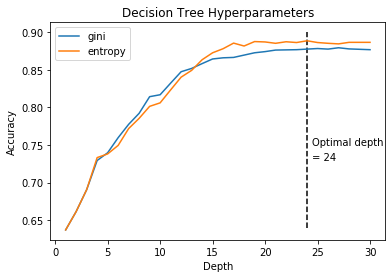

In [27]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')

plt.vlines(24, 0.64, 0.90, linestyle = '--')
plt.annotate('Optimal depth', xy = (24.5, .75))
plt.annotate('= 24', xy = (24.5, .73))
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Hyperparameters')
plt.legend()
#plt.show()
plt.savefig('../figures/DTHyperparameters.png')

## Run the Decision Tree model using the identified hyperparameters

In [28]:
# Initialize and fit the model
modelDT = DecisionTreeClassifier(criterion=crit, max_depth=depth, random_state=21)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=24, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [29]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict_proba(X_test)

## Model evaluation metrics

In [30]:
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))

Model Metrics
Accuracy: 0.8886316872427984
Balanced accuracy: 0.8927945301542777
Precision score for "Yes" 0.9364386220281417
Recall score for "No" 0.9208937198067633


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, dt_pred))

[[1525  131]
 [ 302 1930]]


In [32]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.83      0.92      0.88      1656
        True       0.94      0.86      0.90      2232

    accuracy                           0.89      3888
   macro avg       0.89      0.89      0.89      3888
weighted avg       0.89      0.89      0.89      3888



In [33]:
importances = modelDT.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature UGDS (0.135399)
2. feature CONTROL (0.094133)
3. feature INEXPFTE (0.088319)
4. feature UG25abv (0.088138)
5. feature TUITFTE (0.080195)
6. feature WDRAW_ORIG_YR4_RT (0.078157)
7. feature DEBT_MDN (0.074085)
8. feature Cost (0.065032)
9. feature Complete (0.060034)
10. feature COMP_ORIG_YR4_RT (0.058083)
11. feature NUMBRANCH (0.050853)
12. feature RetentionFT (0.049915)
13. feature PFTFAC (0.034171)
14. feature ENRL_ORIG_YR4_RT (0.029694)
15. feature PREDDEG (0.013791)


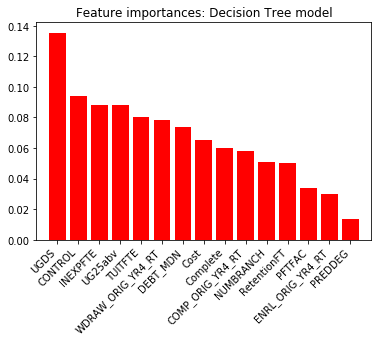

In [34]:
# Plot the impurity-based feature importances of the model
plt.figure()
fig=plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center")
plt.title("Feature importances: Decision Tree model")
plt.xticks(range(X.shape[1]), names, rotation=45, horizontalalignment='right')
plt.xlim([-1, X.shape[1]])
plt.savefig('../figures/DTFeatureImportance.png',bbox_inches='tight')

Enrollment (UGDS) is the most prominent feature that predicts open schools. Having higher enrollment increases the prediction that a school is currently operating. 

# AdaBoost model
## Explore the n_estimators hyperparameter

In [35]:
ABmax_depth = []
score_a = []
score_b = []

for i in range(105, 131, 1):
    atree = AdaBoostClassifier(n_estimators=i, random_state=21)
    atree.fit(X_train, y_train)
    apredict = gtree.predict(X_test)
    score_a.append(metrics.accuracy_score(y_test, apredict))
    ##
    btree = AdaBoostClassifier(modelDT, n_estimators=i, random_state=21)
    btree.fit(X_train, y_train)
    bpredict = btree.predict(X_test)
    score_b.append(metrics.accuracy_score(y_test, bpredict))
    ##
    ABmax_depth.append(i)

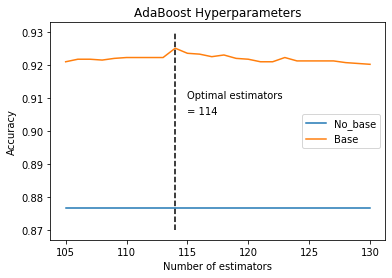

In [36]:
adatrees = pd.DataFrame({'score_a':pd.Series(score_a),
                     'score_b':pd.Series(score_b),
                     'n_estimators':pd.Series(ABmax_depth)})

plt.plot('n_estimators', 'score_a', data=adatrees, label='No_base')
plt.plot('n_estimators', 'score_b', data=adatrees, label='Base')
plt.vlines(114, 0.87, 0.93, linestyle = '--')
plt.annotate('Optimal estimators', xy = (115, .91))
plt.annotate('= 114', xy = (115, .905))
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.title('AdaBoost Hyperparameters')
#plt.show()
plt.savefig('../figures/ABHyperparameters.png')

In [37]:
ideal_estimators = max(score_b)
idx = score_b.index(ideal_estimators)
print(ABmax_depth[idx])

114


## Run the AdaBoost model using the identified hyperparameter

In [38]:
# Initialize and fit the model
modelAB = AdaBoostClassifier(modelDT, n_estimators=ABmax_depth[idx], random_state=21)
modelAB.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=24,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                      

In [39]:
# Use the trained tree to predict the testing data
AB_pred = modelAB.predict(X_test)
AB_pred_prob = modelAB.predict_proba(X_test)

## Model evaluation metrics

In [40]:
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, AB_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, AB_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, AB_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, AB_pred, pos_label = 0))

Model Metrics
Accuracy: 0.9251543209876543
Balanced accuracy: 0.9254616643291258
Precision score for "Yes" 0.9449793672627235
Recall score for "No" 0.927536231884058


In [41]:
print(confusion_matrix(y_test, AB_pred))

[[1536  120]
 [ 171 2061]]


In [42]:
print(classification_report(y_test, AB_pred))

              precision    recall  f1-score   support

       False       0.90      0.93      0.91      1656
        True       0.94      0.92      0.93      2232

    accuracy                           0.93      3888
   macro avg       0.92      0.93      0.92      3888
weighted avg       0.93      0.93      0.93      3888



In [43]:
importances = modelAB.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelAB.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature RetentionFT (nan)
2. feature Cost (nan)
3. feature DEBT_MDN (nan)
4. feature ENRL_ORIG_YR4_RT (nan)
5. feature WDRAW_ORIG_YR4_RT (nan)
6. feature COMP_ORIG_YR4_RT (nan)
7. feature UG25abv (nan)
8. feature PFTFAC (nan)
9. feature INEXPFTE (nan)
10. feature TUITFTE (nan)
11. feature UGDS (nan)
12. feature PREDDEG (nan)
13. feature NUMBRANCH (nan)
14. feature CONTROL (-0.024307)
15. feature Complete (-0.055621)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:578: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


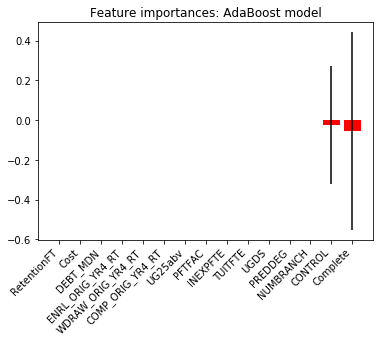

In [44]:
# Plot the feature importances of the model
plt.figure()
plt.title("Feature importances: AdaBoost model")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), names, rotation=45, horizontalalignment='right')
plt.xlim([-1, X.shape[1]])
#plt.show()
plt.savefig('../figures/ABFeatureImportance.png',bbox_inches='tight')

# Results
We are interested in predicting schools that might be in danger of closing. This would be schools that are currently open, but that the model predicts are closed (a.k.a 'false negatives').

## Put predicted results in a dataframe, and merge with identity data

In [45]:
# Record actual and predicted values for test set.
result_dict = {'CURROPER':y_test, 'Predicted':AB_pred}
results = pd.DataFrame(result_dict)

In [46]:
# Join actual and predicted values for test set to the features used by the model.
predicted = pd.concat([X_test, results], axis=1)
predicted.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
29518,4,1,3,172.0,11067.0,6322.0,0.4000,0.7151,0.558824,0.214286,0.000000,12417.0,26213.0,0.3636,0.6364,True,True
25278,1,1,3,270.0,5128.0,6008.0,0.4375,0.5444,0.446097,0.289963,0.000000,4857.0,15973.0,0.5523,0.6552,True,True
26172,1,2,3,557.0,9465.0,3661.0,0.3235,0.5673,0.414948,0.314433,0.018041,9500.0,22907.0,0.2300,0.6129,True,True
4329,1,1,3,129.0,7651.0,8874.0,0.4375,0.2479,0.576687,0.239264,0.000000,10885.0,38377.0,0.6124,0.6429,False,False
25384,1,2,1,3381.0,2635.0,5570.0,0.2457,0.2190,0.296157,0.247174,0.020231,5906.0,13481.0,0.3339,0.6095,True,True


In [47]:
# Add a column labeling the results as TP, TN, FP or FN, for ease of access.
predicted['Result'] = np.nan
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==True), 'Result'] = 'TP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==False), 'Result'] = 'TN'
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==False), 'Result'] = 'FP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==True), 'Result'] = 'FN'
print(predicted.Result)

29518    TP
25278    TP
26172    TP
4329     TN
25384    TP
         ..
26843    TP
22649    TN
27248    TP
14348    TN
29292    TP
Name: Result, Length: 3888, dtype: object


In [48]:
# Explore schools that are closed, but predicted to be open
false_pos = predicted.loc[(predicted.Predicted == True) & (predicted.CURROPER == False)]
false_pos.shape

(120, 18)

In [49]:
# Explore schools that are currently operating, but predicted to be closed. These are the interesting cases.
false_neg = predicted.loc[(predicted.Predicted==False) & (predicted.CURROPER==True)]
false_neg.shape

(171, 18)

In [50]:
# Merge school name and identity information to the predictions
to_graph = predicted.merge(identity, how='left', left_index=True, right_index=True)
to_graph.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,Complete,RetentionFT,CURROPER,Predicted,Result,OPEID,INSTNM,CITY,Governance,PREDDEG_N
69,1,1,3,86.0,8740.0,10208.0,0.4375,0.5463,0.435897,0.256410,...,0.4800,0.6087,False,False,TN,01293700,empire beauty school-paradise valley,Phoenix,Private for-profit,Certificate
70,2,1,3,149.0,9033.0,7898.0,0.4375,0.4894,0.653959,0.196481,...,0.7025,0.5000,False,False,TN,00886500,empire beauty school-tucson,Tucson,Private for-profit,Certificate
71,1,1,2,2.0,49859.0,33004.0,0.6301,0.5550,0.600000,0.000000,...,0.7570,0.7647,False,False,TN,00107000,thunderbird school of global management,Glendale,Private nonprofit,Certificate
85,1,1,3,252.0,6997.0,3720.0,0.4375,0.3333,0.754839,0.096774,...,0.7534,0.8772,False,False,TN,02561900,brillare hairdressing academy,Scottsdale,Private for-profit,Certificate
104,1,1,3,137.0,3629.0,596.0,0.4375,0.8802,0.753425,0.173333,...,0.8000,0.9762,False,True,FP,02192300,maricopa beauty college llc,Avondale,Private for-profit,Certificate


In [51]:
to_graph.duplicated().sum()

399

In [52]:
to_graph.drop_duplicates(inplace=True)
to_graph.shape

(3489, 23)

In [53]:
to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3489 entries, 69 to 30685
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          3489 non-null   int64  
 1   PREDDEG            3489 non-null   int64  
 2   CONTROL            3489 non-null   int64  
 3   UGDS               3489 non-null   float64
 4   TUITFTE            3489 non-null   float64
 5   INEXPFTE           3489 non-null   float64
 6   PFTFAC             3489 non-null   float64
 7   UG25abv            3489 non-null   float64
 8   COMP_ORIG_YR4_RT   3489 non-null   float64
 9   WDRAW_ORIG_YR4_RT  3489 non-null   float64
 10  ENRL_ORIG_YR4_RT   3489 non-null   float64
 11  DEBT_MDN           3489 non-null   float64
 12  Cost               3489 non-null   float64
 13  Complete           3489 non-null   float64
 14  RetentionFT        3489 non-null   float64
 15  CURROPER           3489 non-null   bool   
 16  Predicted          348

## Rerun evaluation metrics
Since the closed schools were resampled before the model was trained, there were duplicated schools in the test set. Once those duplicates are dropped, we can rerun the model metrics to see how well the model performs on the non-duplicated data.

In [54]:
print(confusion_matrix(to_graph['CURROPER'], to_graph['Predicted']))

[[1167   90]
 [ 171 2061]]


In [55]:
print(classification_report(to_graph['CURROPER'], to_graph['Predicted']))

              precision    recall  f1-score   support

       False       0.87      0.93      0.90      1257
        True       0.96      0.92      0.94      2232

    accuracy                           0.93      3489
   macro avg       0.92      0.93      0.92      3489
weighted avg       0.93      0.93      0.93      3489



## Explore distribution of schools by predictions and features.

In [56]:
degreeControl = to_graph.pivot_table(index='PREDDEG_N', columns=['Governance','CURROPER'], aggfunc='size')
print(degreeControl)

Governance     Private for-profit        Private nonprofit        Public  \
CURROPER                    False  True              False  True   False   
PREDDEG_N                                                                  
Associates                  114.0  175.0              13.0   52.0   21.0   
Bachelor                     72.0   78.0              43.0  375.0    3.0   
Certificate                 693.0  714.0              71.0   50.0   59.0   
Graduate                     30.0    9.0              20.0   79.0    NaN   
Not classified               82.0   81.0              19.0   33.0   17.0   

Governance             
CURROPER        True   
PREDDEG_N              
Associates      215.0  
Bachelor        167.0  
Certificate     178.0  
Graduate          4.0  
Not classified   22.0  


In [57]:
predControl = to_graph.pivot_table(index='PREDDEG_N', columns=['Governance','Result'], aggfunc='size')
print(predControl)

Governance     Private for-profit                     Private nonprofit        \
Result                         FN    FP     TN     TP                FN    FP   
PREDDEG_N                                                                       
Associates                   17.0   7.0  107.0  158.0               3.0   3.0   
Bachelor                      6.0   NaN   72.0   72.0               7.0  11.0   
Certificate                  97.0  51.0  642.0  617.0              12.0   6.0   
Graduate                      1.0   NaN   30.0    8.0               2.0   NaN   
Not classified                7.0   4.0   78.0   74.0               7.0   NaN   

Governance                  Public                    
Result            TN     TP     FN   FP    TN     TP  
PREDDEG_N                                             
Associates      10.0   49.0    NaN  2.0  19.0  215.0  
Bachelor        32.0  368.0    NaN  2.0   1.0  167.0  
Certificate     65.0   38.0   11.0  3.0  56.0  167.0  
Graduate        20.0 

In [58]:
controlPivot = to_graph.pivot_table(index='Governance', columns = 'Result', aggfunc='size')
print(controlPivot)

Result               FN  FP   TN   TP
Governance                           
Private for-profit  128  62  929  929
Private nonprofit    31  20  146  558
Public               12   8   92  574


In [59]:
false_neg = to_graph.loc[to_graph.Result == 'FN']
false_neg.shape

(171, 23)

# Graphically explore the results

## UGDS - Undergraduate enrollment

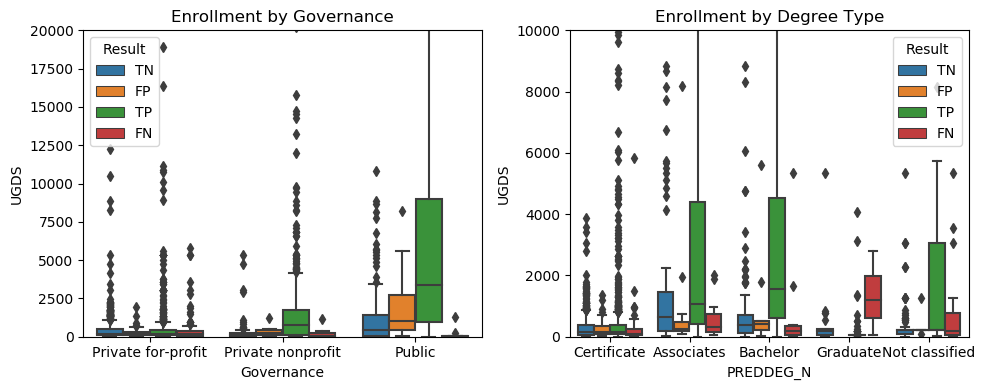

In [60]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('Governance', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 20000)
plt.title('Enrollment by Governance')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG_N', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 10000)
plt.title('Enrollment by Degree Type')
plt.tight_layout()

Text(0.5, 0.98, 'Tuition Revenue by Enrollment')

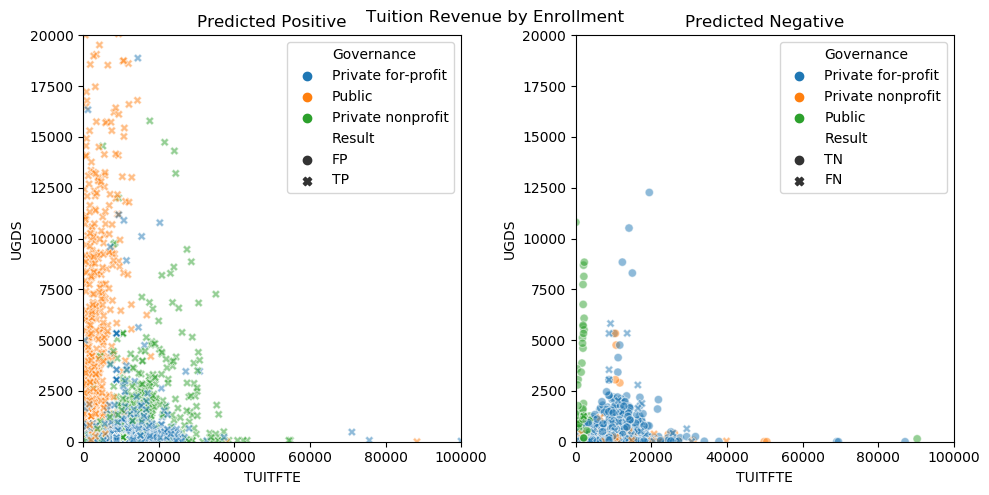

In [61]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue = 'Governance',style='Result', alpha=0.5 )
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue = 'Governance', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.tight_layout()
fig.suptitle('Tuition Revenue by Enrollment')
#plt.savefig('../figures/ResultsTuitionEnrollmentControl.png',bbox_inches='tight')

Text(0.5, 0.98, 'Tuition Revenue by Enrollment')

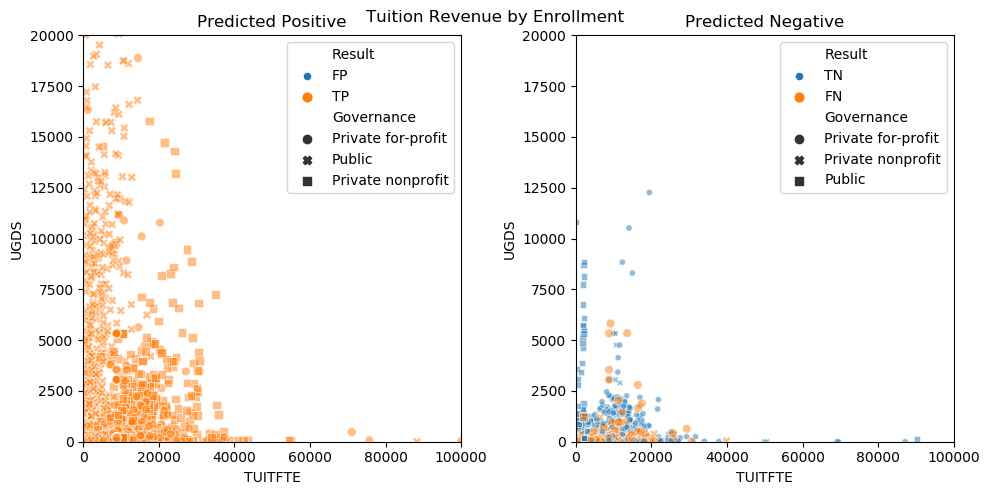

In [62]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue='Result',style='Governance', size='Result', sizes={40, 20}, alpha=0.5)
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.tight_layout()
fig.suptitle('Tuition Revenue by Enrollment')
#plt.savefig('../figures/ResultsTuitionEnrollment.png',bbox_inches='tight')

## Tuition revenue and Cost

Text(0.5, 0.98, 'Tuition Revenue by Cost')

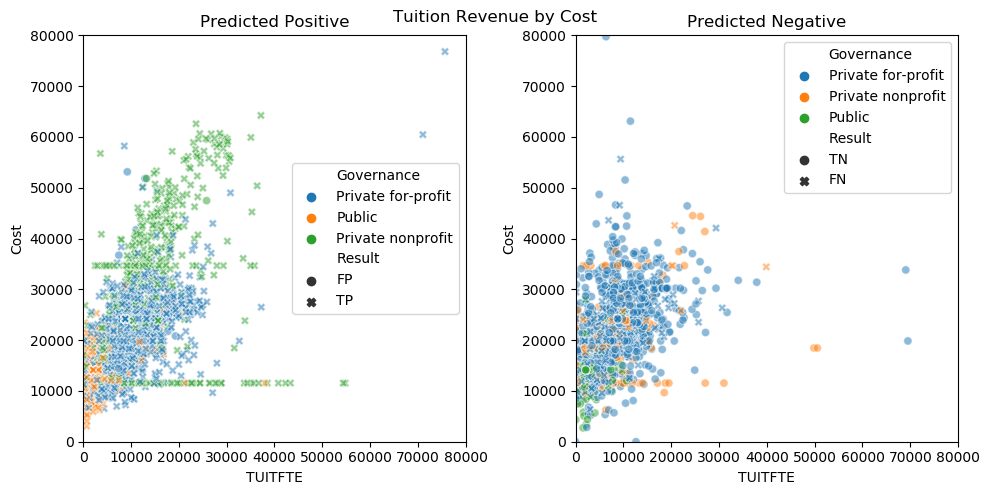

In [63]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue ='Governance', style='Result', alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Governance', style='Result', alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Negative')

plt.tight_layout()
fig.suptitle('Tuition Revenue by Cost')
#plt.savefig('../figures/ResultsTuitionCostControl.png',bbox_inches='tight')

Text(0.5, 0.98, 'Tuition Revenue by Cost')

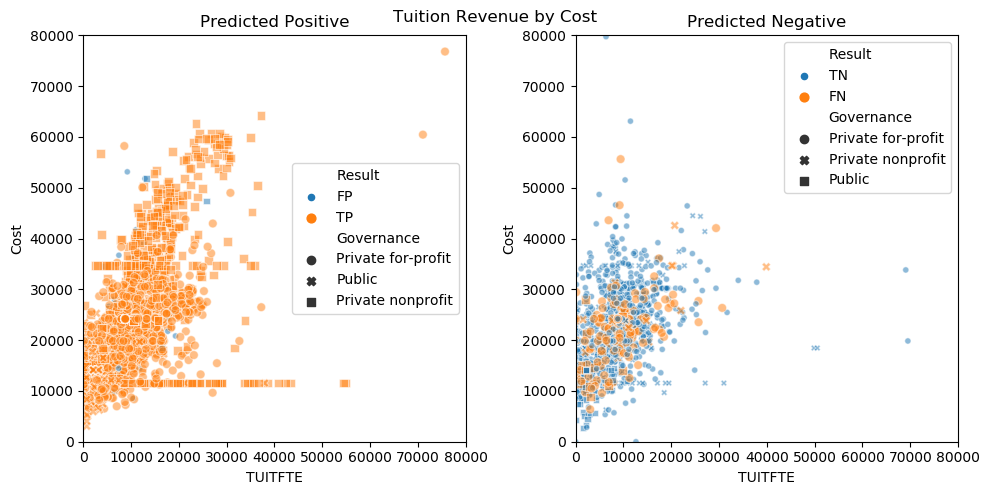

In [64]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue ='Result', style='Governance', size='Result', sizes={20, 40}, alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result', style='Governance', size='Result', sizes={20,40}, alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Negative')

plt.tight_layout()
fig.suptitle('Tuition Revenue by Cost')
#plt.savefig('../figures/ResultsTuitionCost.png',bbox_inches='tight')

## Cost and Debt

Text(0.5, 0.98, 'Median debt by Cost')

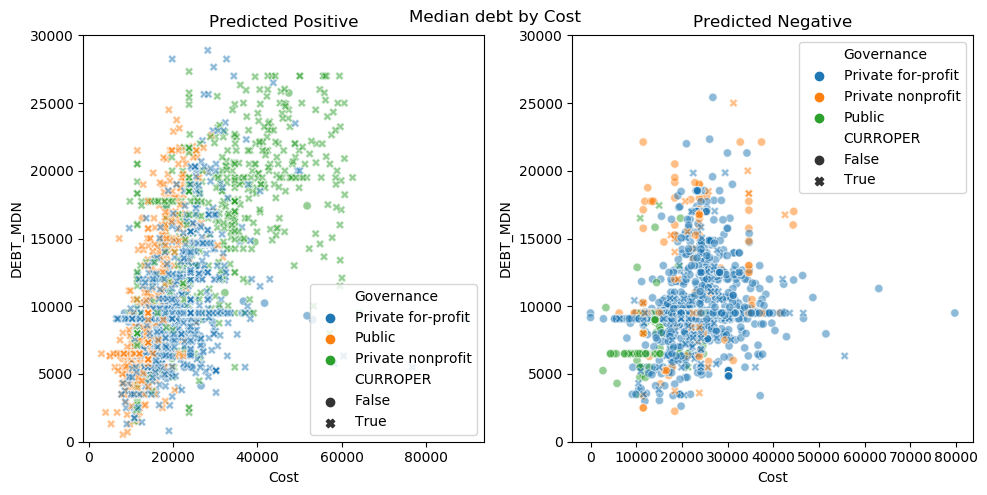

In [65]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='Governance', style='CURROPER', alpha=0.5)
plt.title('Predicted Positive')
plt.ylim(0,30000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==False], hue='Governance', style='CURROPER', alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)

plt.tight_layout()
fig.suptitle('Median debt by Cost')
#plt.savefig('../figures/ResultsCostDebtControl.png',bbox_inches='tight')

Text(0.5, 0.98, 'Median debt by Cost')

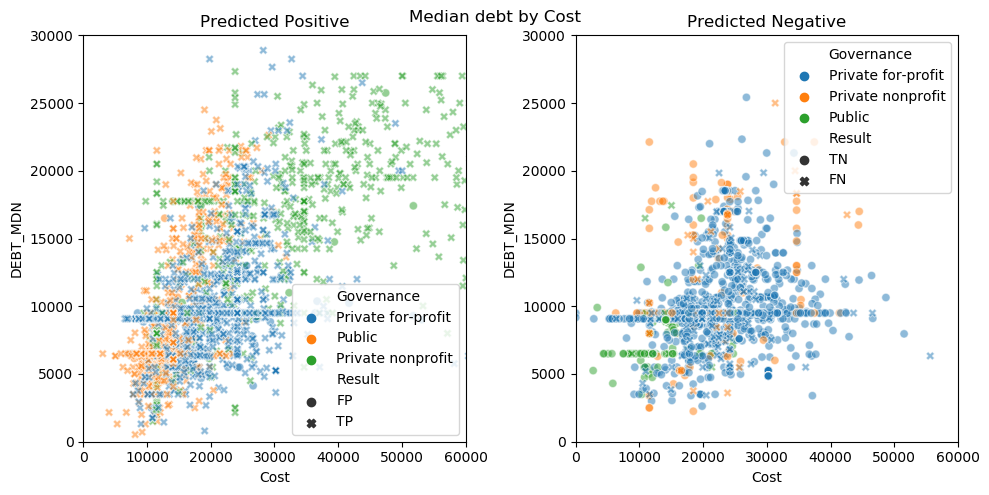

In [66]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='Governance', style='Result', alpha=0.5)
plt.title('Predicted Positive')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==False], hue='Governance', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.tight_layout()
fig.suptitle('Median debt by Cost')
#plt.savefig('../figures/ResultsTuitionCostPositive.png',bbox_inches='tight')

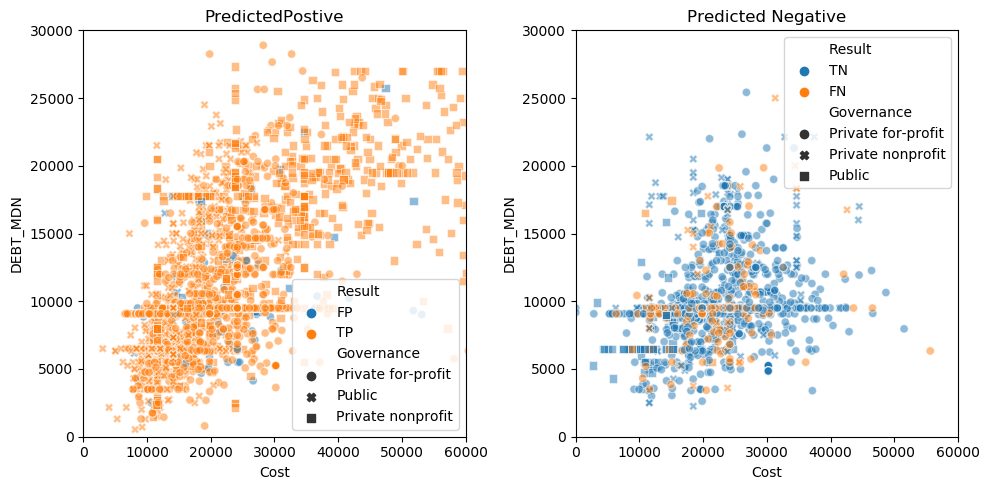

In [67]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='Governance', alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='Governance', alpha=0.5)
plt.title('PredictedPostive')
plt.ylim(0,30000)
plt.xlim(0,60000)


plt.tight_layout()
#plt.show()
#plt.savefig('../figures/ResultsTuitionCostNegative.png',bbox_inches='tight')

## Number of Branches

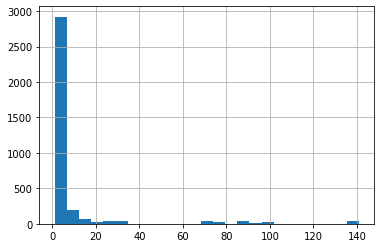

In [68]:
to_graph.NUMBRANCH.hist(bins=25)

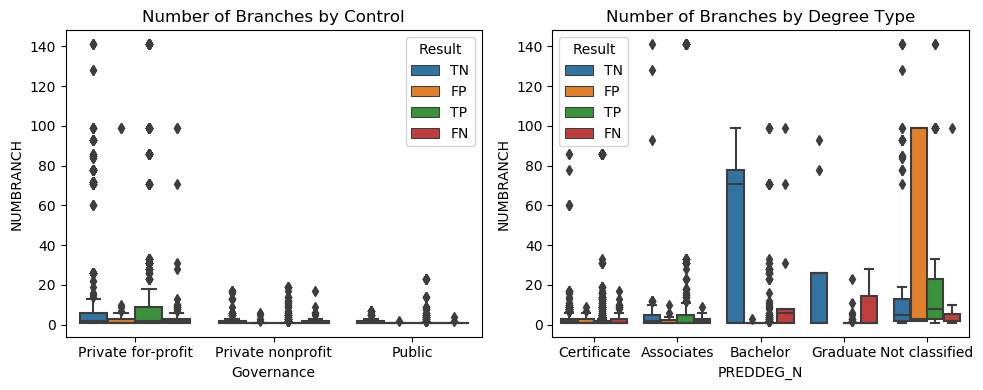

In [69]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('Governance', 'NUMBRANCH', data = to_graph, hue = 'Result')
plt.title('Number of Branches by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG_N', 'NUMBRANCH', data = to_graph, hue = 'Result')
plt.title('Number of Branches by Degree Type')
plt.tight_layout()

Text(0.5, 0.98, 'Number of branches by Enrollment')

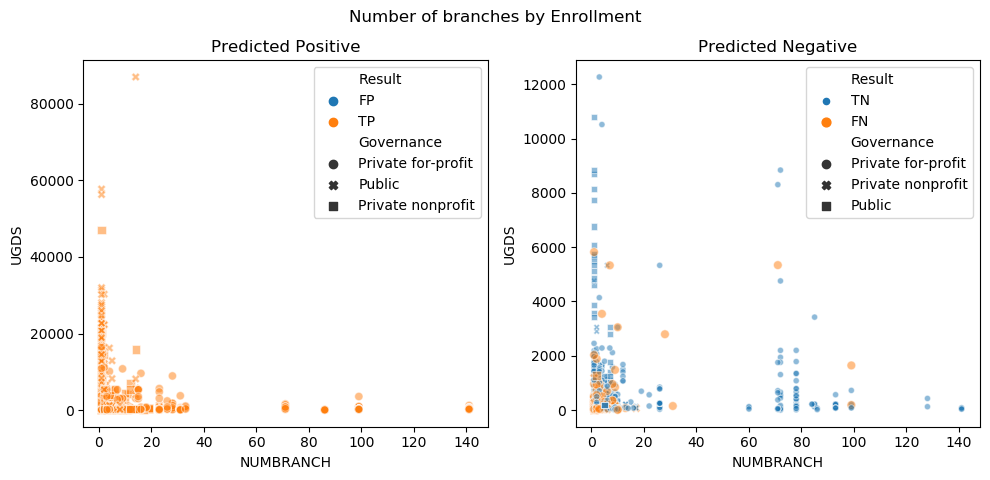

In [70]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='Governance', alpha=0.5)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.title('Predicted Negative')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Number of branches by Enrollment')

## Instructional Expenditure

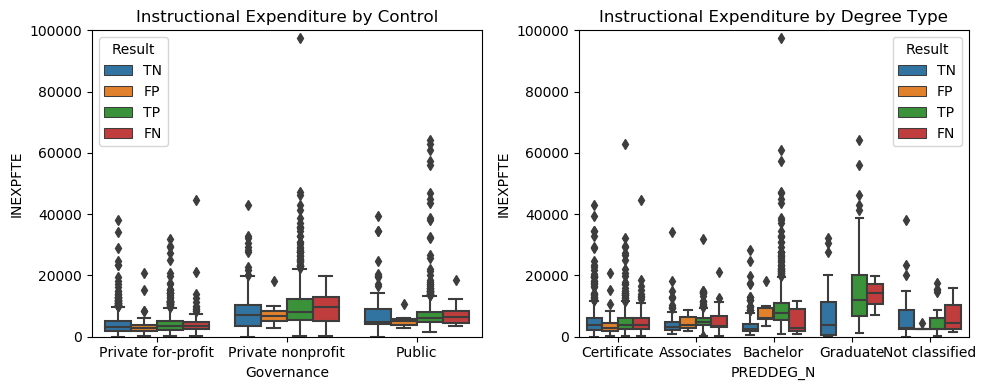

In [71]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('Governance', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG_N', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Degree Type')
plt.tight_layout()

Text(0.5, 0.98, 'Expenditure by Enrollment')

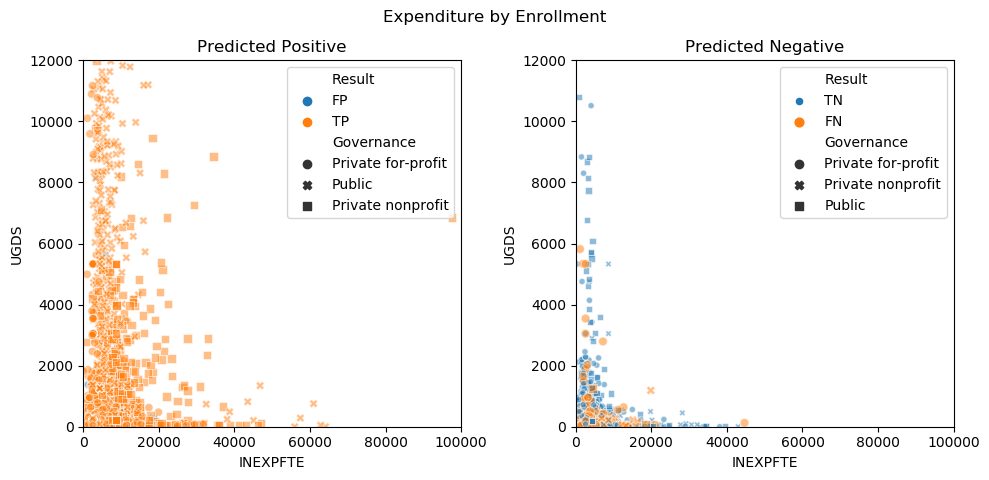

In [72]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('', 'UGDS', data=to_graph, hue = 'Result')
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='Governance', alpha=0.5)
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
#sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('Predicted Negative')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Expenditure by Enrollment')
#plt.savefig('../figures/ResultsExpenditureUGDS.png',bbox_inches='tight')

Text(0.5, 0.98, 'Expenditure by Cost')

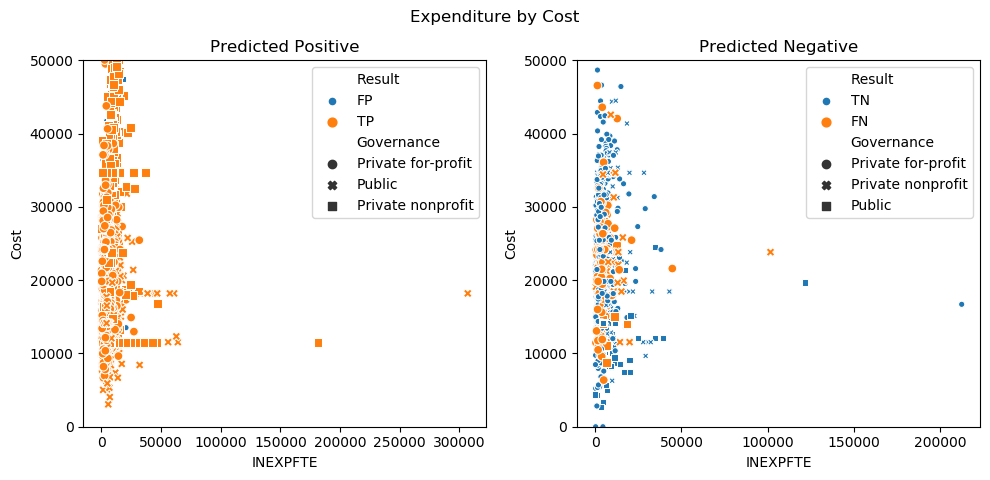

In [73]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='Governance',size='Result', sizes={20,40})#, alpha=0.5)
plt.ylim(0, 50000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result', style='Governance', size='Result', sizes={20,40})
plt.ylim(0, 50000)
plt.title('Predicted Negative')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Expenditure by Cost')
#plt.savefig('../figures/ResultsExpenditureCostPositive.png',bbox_inches='tight')

## Graphs of 4yr bachelors institutions

In [74]:
bach = to_graph.loc[to_graph['PREDDEG_N']=='Bachelor']
bach = bach.copy()
bach.shape

(738, 23)

Text(0.5, 0.98, "Bachelor's - Cost by Debt")

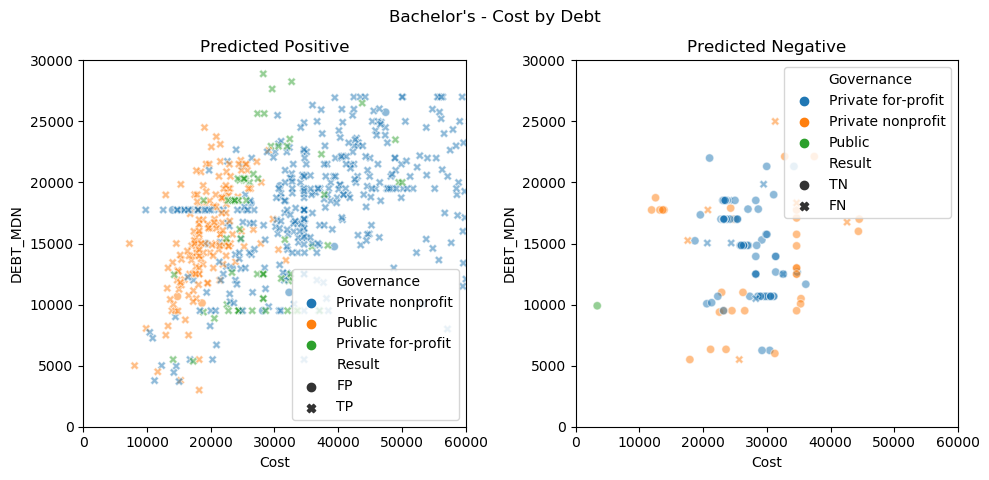

In [75]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=bach.loc[bach.Predicted==True], hue='Governance', style='Result', alpha=0.5)
plt.title('Predicted Positive')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=bach[bach.Predicted==False], hue='Governance', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Bachelor's - Cost by Debt")
#plt.savefig('../figures/ResultsBachTuitionCostNegative.png',bbox_inches='tight')

Text(0.5, 0.98, "Bachelor's - Cost by Debt")

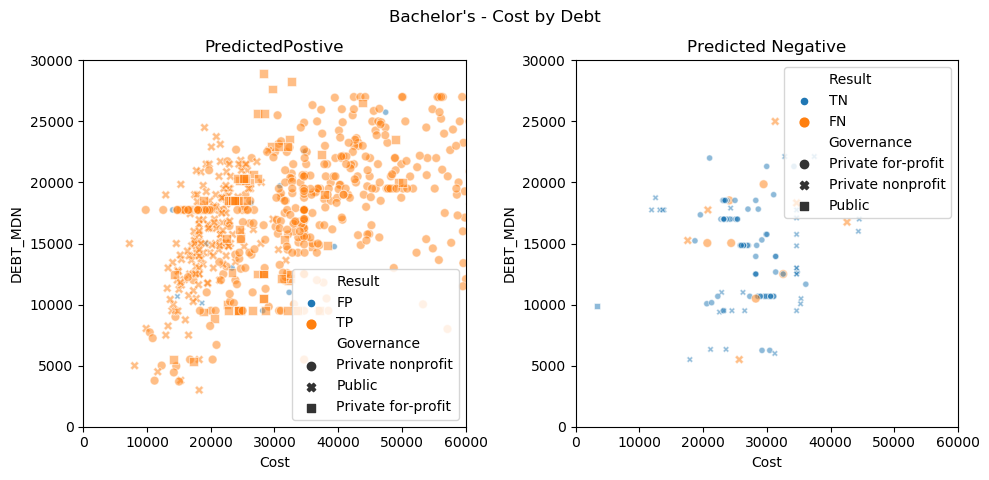

In [76]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=bach.loc[bach.Predicted==True], hue='Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.title('PredictedPostive')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=bach.loc[bach.Predicted==False], hue='Result', style='Governance', size='Result', sizes={20,40}, alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Bachelor's - Cost by Debt")
#plt.savefig('../figures/ResultsBachTuitionCostPositive.png',bbox_inches='tight')

Text(0.5, 0.98, "Bachelor's - Tuition Revenue by Cost")

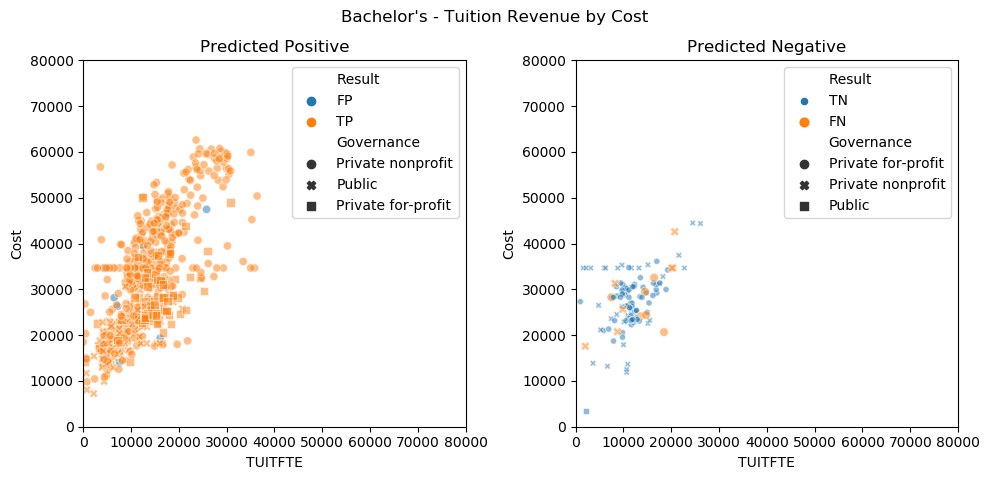

In [77]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=bach.loc[bach.Predicted==True], hue ='Result', style='Governance', alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=bach.loc[bach.Predicted==False], hue = 'Result', style='Governance',size='Result', sizes={20,40}, alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Negative')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Bachelor's - Tuition Revenue by Cost")
#plt.savefig('../figures/ResultsBachTuitionCost.png',bbox_inches='tight')

Text(0.5, 0.98, "Bachelor's - Tuition Revenue by Enrollment")

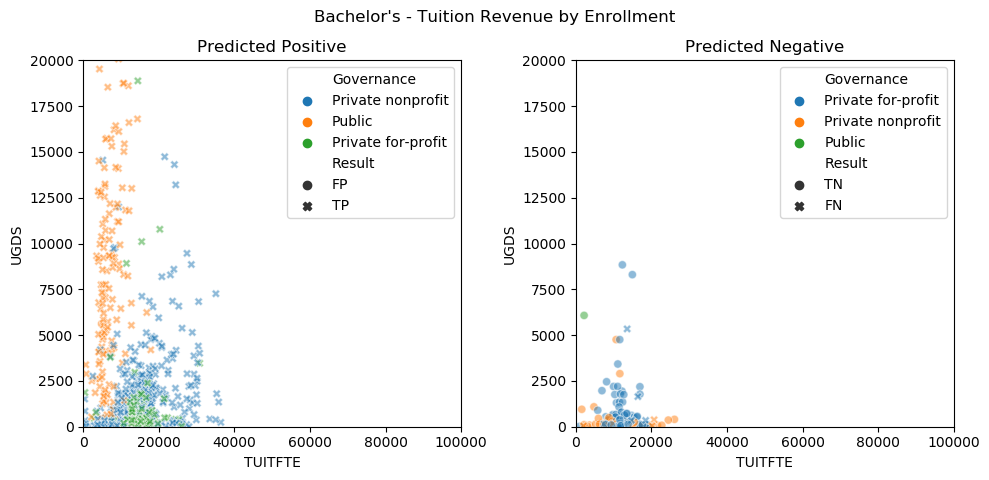

In [78]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=bach.loc[bach.Predicted==True], hue = 'Governance',style='Result', alpha=0.5 )
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=bach.loc[bach.Predicted==False], hue = 'Governance', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Bachelor's - Tuition Revenue by Enrollment")
#plt.savefig('../figures/ResultsBachTuitionEnrollmentControl.png',bbox_inches='tight')

## Explore predictions of various schools
I know there are several private colleges whose name starts with 'Bethel', that are members of the potential client's organization. I'm going to explore the predictions made for schools with similar names, as a proxy for the client's member institutions.

In [79]:
bethel = data.loc[data['INSTNM'].str.startswith('bethel')]
bethel = bethel.copy()
bethel.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,Cost,PREDDEG_N,Governance,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,Complete,RetentionFT,RetentionPT
24068,Other,bethel college-indiana,Mishawaka,1,3,4,2,3.0,0.7158,1579.0,...,33617.0,Bachelor,Private nonprofit,large,highest,high,med,0.64660,0.84070,0.5714
24232,00190500,bethel college-north newton,North Newton,1,3,3,2,4.0,0.6440,482.0,...,33781.0,Bachelor,Private nonprofit,medium,highest,high,med,0.52780,0.70300,NaN
24784,00348000,bethel university,Saint Paul,4,3,4,2,4.0,0.9485,3178.0,...,42692.0,Bachelor,Private nonprofit,xl,highest,high,high,0.71360,0.85040,0.0000
24785,Other,bethel seminary-st paul,Saint Paul,4,4,4,2,4.0,NaN,5180.0,...,11543.0,Graduate,Private nonprofit,NaN,highest,high,high,0.55125,0.64165,NaN
26464,00348000,bethel university,McKenzie,1,3,4,2,5.0,0.5103,5063.0,...,26864.0,Bachelor,Private nonprofit,xl,high,high,low,0.30200,0.55560,0.0882


In [80]:
bethel.CURROPER.value_counts()

False    8
True     7
Name: CURROPER, dtype: int64

In [81]:
## Run the Bethel schools through the model and see what it predicts
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins','Governance',\
           'TuitionBins','ExpenditureBins','FacultyBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year', 'PREDDEG_N']
bethel_test = bethel.drop(to_drop, axis=1)

In [82]:
bethel_test = bethel_test.drop('CURROPER', axis=1)
bethel_pred = modelAB.predict(bethel_test)

In [83]:
bethel['Predict'] = bethel_pred
print(bethel[['INSTNM','CITY', 'CURROPER', 'Predict']].head(15))

                            INSTNM          CITY  CURROPER  Predict
24068       bethel college-indiana     Mishawaka      True     True
24232  bethel college-north newton  North Newton      True     True
24784            bethel university    Saint Paul      True     True
24785      bethel seminary-st paul    Saint Paul      True     True
26464            bethel university      McKenzie      True     True
27321    bethel seminary-san diego     San Diego      True     True
29472               bethel college       Hampton      True     True
19748  bethel seminary of the east      Landover     False    False
12130  bethel seminary of the east  Willow Grove     False    False
4755   bethel seminary of the east  Willow Grove     False    False
19748  bethel seminary of the east      Landover     False    False
4755   bethel seminary of the east  Willow Grove     False    False
12130  bethel seminary of the east  Willow Grove     False    False
4755   bethel seminary of the east  Willow Grove

## Explore the private nonprofit, bachelor's granting institutions from the test set.

In [84]:
dangerBachPrivate = bach.loc[(bach['CONTROL']==2) & (bach['Result']=='FN')]
dangerBachPrivate.shape

(7, 23)

In [85]:
dangerBachPrivate[['INSTNM', 'CITY', 'Governance', 'PREDDEG_N']]

,INSTNM,CITY,Governance,PREDDEG_N
23501,naropa university,Boulder,Private nonprofit,Bachelor
25138,thomas more college of liberal arts,Merrimack,Private nonprofit,Bachelor
25399,liu brentwood,Brentwood,Private nonprofit,Bachelor
27926,messenger college,Euless,Private nonprofit,Bachelor
28544,williamson christian college,Franklin,Private nonprofit,Bachelor
28735,ecclesia college,Springdale,Private nonprofit,Bachelor
29043,liu riverhead,Riverhead,Private nonprofit,Bachelor


### Notes on false negative, private nonprofit, bachelor's granting institutions
- Naropa Univerisity still in operation (at least they still have an active website)
- Thomas More College of Liberal Arts is still in operation
- Williamson Christian College is still in operation
- Ecclesia College is still open
- Messenger College is still open
- LIU = Long Island University - Brentwood is still open, Riverhead is still open